In [9]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; 
#sns.set(style="ticks", color_codes=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, make_scorer

from sklearn.model_selection import LeaveOneGroupOut, validation_curve
import pandas as pd
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

## This project was broken into following steps:
1. Data Investigation and Visualization. Please see comments for analysis <br />
Summary of analysis: There are 9 wells with close to 5000 data points, but only 7 wells have all the necessary
    information ( all of the logs). <br />
    Use information from 7 wells to model and predict missing curve, apply model to the 2 wells with missing curve and evaluate results.<br />
    Incorporate new 'synthetic'curves and use all 9 wells with complete information to predict Facies (rock types)<br />
    Evaluate results <br />
    
2. Use Well - Cross H Cattle to predict PE 
3. Validate the prediction by comparing predicted ('syntetic')PE with Actual
4. Create new Data Set with 7 wells for PE prediction
5. Predict PE for Alexander D well using RF prediction from 7 wells
6. Predict PE for Kimzy well
7. Predict PE for Alexander D well using RF prediction from 7 wells
8. Choose model to predict Facies from 9 wells
9. Evaluate results
11. Choose parameters for Random Forest
12. Getting Well plots set up
13. Apply RF model to see how well it will predict facies
10. Discuss next steps



In [10]:
# The nine discrete facies (classes of rocks) are:
1 - Nonmarine sandstone
2 - Nonmarine coarse siltstone
3 - Nonmarine fine siltstone
4 - Marine siltstone and shale
5 - Mudstone (limestone)
6 - Wackestone (limestone)
7 - Dolomite
8 - Packstone-grainstone (limestone)
9 - Phylloid-algal bafflestone (limestone)

Need to add column Facies Labels 

Facies	Label	Adjacent Facies
1       SS	    2
2	    CSiS	1,3
3	    FSiS	2
4	    SiSh	5
5	    MS	4,6
6	    WS	5,7
7	    D	6,8
8	    PS	6,7,9
9	    BS	7,8


SyntaxError: invalid syntax (<ipython-input-10-1e22b2e4f2ee>, line 2)

In [11]:
def Facies(x): # to assign numbers to Facies names. This will be used in plots
 
        if x==1:
            return "SS"
        elif x==2:
            return "CSiS"
        elif x==3:
            return "FSiS"
        elif x==4:
            return "SiSh"
        elif x==5:
            return "MS"
        elif x==6:
            return "WS"
        elif x==7:
            return "D"
        elif x==8:
            return "PS"
        else:
            return "BS"

In [12]:
#df_drop["Facies_X"].head()

# Data Investigation and Visualization

In [13]:
training_data = pd.read_csv('facies_vectors.csv')
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4974,0,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
4975,0,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
4976,0,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
4977,0,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


In [14]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4062.000000,4979.000000,4979.000000
mean,3.752561,2920.237297,63.713364,0.660690,4.144012,12.943383,3.710540,1.545089,0.524178
std,2.814085,131.086857,29.979746,0.258971,5.049037,6.871145,0.852033,0.498013,0.286069
min,0.000000,2573.500000,10.149000,-0.468000,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2837.750000,43.197000,0.503623,1.330000,8.350000,3.130000,1.000000,0.281000
50%,3.000000,2943.000000,64.085000,0.645226,3.900000,11.800000,3.537000,2.000000,0.530000
75%,6.000000,3016.000000,78.555000,0.829000,7.000000,15.826000,4.298250,2.000000,0.771500
max,9.000000,3160.500000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [15]:
training_data.PE.isnull().any()

True

Notes: PE curve only has 4062 observations. Need to 1. drop null values so they dont interfere with the predictions
2.Use other 7 wells to predict PE on two missing wells and then use all 9 wells to predict facies. 

In [16]:
training_data.shape

(4979, 11)

In [17]:
training_data['Well Name'].value_counts() #to see how many observations are in each well

CROSS H CATTLE     501
STUART             474
SHRIMPLIN          471
ALEXANDER D        466
NEWBY              463
                  ... 
KIMZEY A           439
NOLAN              415
CHURCHMAN BIBLE    404
CRAWFORD           356
Recruit F9          80
Name: Well Name, Length: 12, dtype: int64

drop Recruit F9 as it doesnt have long enough data

In [18]:
df_drop = training_data #new dataset for further analysis
df_drop=df_drop[df_drop["Well Name"] !='Recruit F9']
df_drop.shape

(4899, 11)

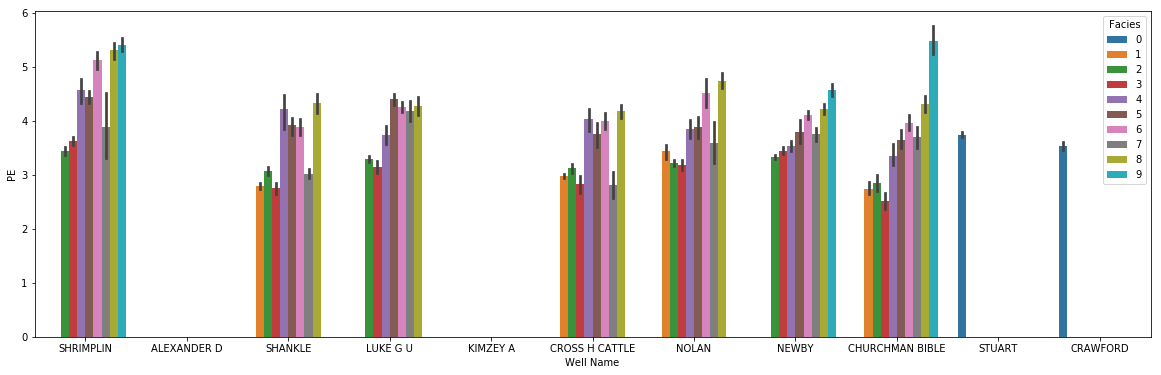

In [19]:
fig, axes = plt.subplots(figsize=(20,6))
sns.barplot(x='Well Name', y='PE',data=df_drop, hue='Facies')

From the plots above we can see that two wells - Alexander D and Kimsey A are missing PE logs.
Could train data using one of the existing wells to predict PE
Stuart and Crawford will be used to test facies predictions. Drop them for now as well


In [20]:
df_drop_stuart = df_drop 
df_drop_stuart=df_drop_stuart[df_drop_stuart["Well Name"] !='STUART']
df_drop_stuart.shape

(4425, 11)

In [21]:
df_drop_stuart['Well Name'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
ALEXANDER D        466
NEWBY              463
LUKE G U           461
SHANKLE            449
KIMZEY A           439
NOLAN              415
CHURCHMAN BIBLE    404
CRAWFORD           356
Name: Well Name, dtype: int64

In [22]:
df_drop = df_drop_stuart #new dataset for further analysis
df_drop=df_drop[df_drop["Well Name"] !='CRAWFORD']
df_drop.shape

(4069, 11)

In [23]:
df_drop['Well Name'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
ALEXANDER D        466
NEWBY              463
LUKE G U           461
SHANKLE            449
KIMZEY A           439
NOLAN              415
CHURCHMAN BIBLE    404
Name: Well Name, dtype: int64

In [24]:
groups=df_drop.groupby('Well Name') #another method to find out which wells are missing PE log

for group, details in groups:
    print(group, details["PE"].isnull().any())

ALEXANDER D True
CHURCHMAN BIBLE False
CROSS H CATTLE False
KIMZEY A True
LUKE G U False
NEWBY False
NOLAN False
SHANKLE False
SHRIMPLIN False


In [25]:
df_drop["Well Name"][training_data["PE"].isnull()]

471     ALEXANDER D
472     ALEXANDER D
473     ALEXANDER D
474     ALEXANDER D
475     ALEXANDER D
           ...     
2281       KIMZEY A
2282       KIMZEY A
2283       KIMZEY A
2284       KIMZEY A
2285       KIMZEY A
Name: Well Name, Length: 905, dtype: object

In [26]:
groups=df_drop.groupby('Well Name') #another method to find out which wells are missing facies

for group, details in groups:
    print(group, details["PE"].isnull().any())

ALEXANDER D True
CHURCHMAN BIBLE False
CROSS H CATTLE False
KIMZEY A True
LUKE G U False
NEWBY False
NOLAN False
SHANKLE False
SHRIMPLIN False


Use Correlation Matrix to see which features (logs) could be used for facies classification 

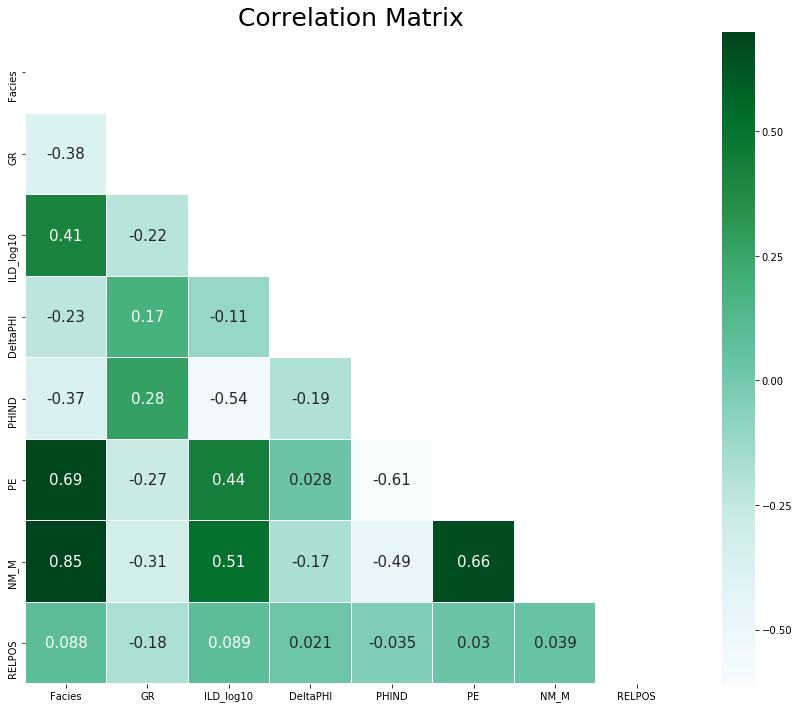

In [27]:
features = ['Facies', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
#here we add Facies into the list of features to see correlations
mask = np.zeros_like(df_drop[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlation Matrix',fontsize=25)

sns.heatmap(df_drop[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":15},mask=mask,cbar_kws={"shrink": 1});

Based on the heatmap, features that help in facies classificaion are Curves : PE, GR, Resistivity (ILD_log10), Both Densities ('DeltaPHI', 'PHIND'). Geologically imposed attributes NM_M and RELPOS have to be used to classify facies and places them at the correct depth

From the Heatmap PE seems to be a good predictor of facies so I would like to start with 
1. finding a good model to predict PE using other wells  to train my model
2. Apply appropriate model to create "new"or synthetic PE to be used in futher Facies Prediction modeling

Definitions for PE log and why it is an important feature

The photoelectric index (Pe) is a supplementary measurement by the latest generation of density logging tools, and records the absorption of low-energy gamma rays by the formation in units of barns per electron. The logged value is a direct function of the aggregate atomic number (Z) of the elements in the formation, and so is a sensitive indicator of mineralogy. The values are less sensitive to pore volume changes than either the neutron or density logs, so that the index is an excellent indicator of mineralogy. The common reservoir mineral reference values are : quartz 1.81 ; dolomite 3.14 ; calcite 5.08 barns/electron. The photoelectric index log is commonly scaled on a range between 0 and 10 barns/electron, and a generalized interpretation guide is given in the figure. The variable compositions of clay minerals means that their position on the scale should only be taken as a broad indication. The ordering of clay minerals on the index is almost entirely a function of their likely content of iron.

The photoelectric index log is particularly useful when considered in conjunction with the neutron/density porosity overlay as an additional input to resolve mixtures of minerals such as commonly occur in "complex carbonates" as cherty dolomitic limestones or anhydritic dolomites. Successful interpretation requires the disposition of the neutron/density porosity traces to be considered simultaneously with the Pe curve. The photoelectric factor curve should be watched most carefully, because it has a finer vertical resolution (about half a foot) than the neutron/density curves (about 2 feet). As a result, the Pe character can give a better reading on lithology in thin beds, where the averaging effect of adjacent thick beds may smooth the neutron and density responses adversely.

In [28]:
df_drop["Facies_X"]=df_drop["Facies"].apply(Facies)

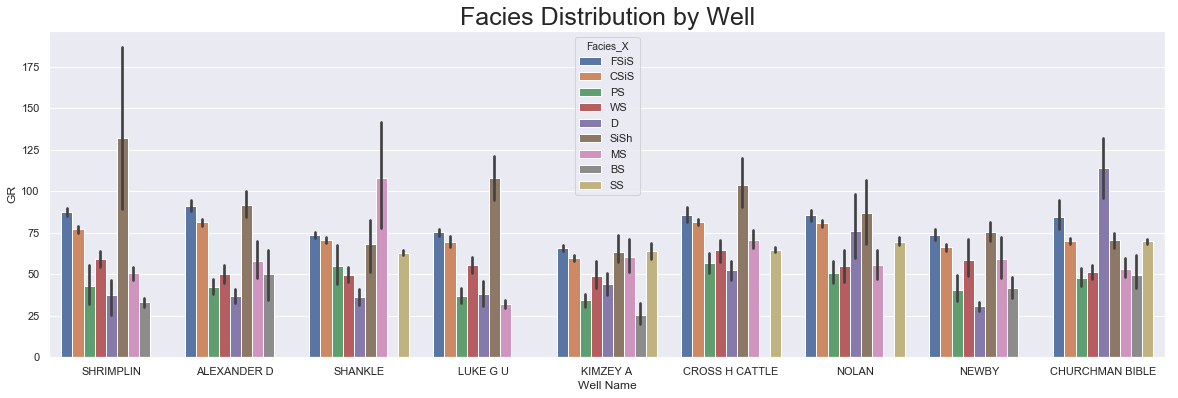

In [155]:
fig, axes = plt.subplots(figsize=(20,6))
plt.title('Facies Distribution by Well',fontsize=25)
sns.barplot(x='Well Name', y='GR',data=df_drop, hue="Facies_X") # mapping wells with Facies represented in each well

This plot shows distribution of Facies/ types of rocks by well. 

Text(0.5, 1.0, 'Proportion of Marine and Non-Marine types in Facies')

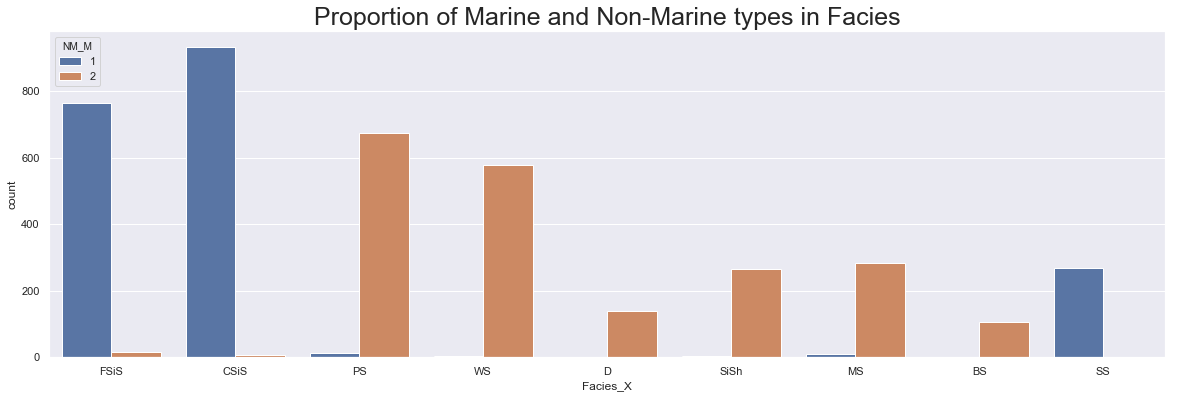

In [156]:
fig, axes = plt.subplots(figsize=(20,6))
sns.countplot(x='Facies_X',data=df_drop, hue='NM_M',)
plt.title('Proportion of Marine and Non-Marine types in Facies',fontsize=25)

Here is another plot showing marine and non-marine types of facies. 

In [31]:
df_drop['Facies'].unique()

array([3, 2, 8, 6, 7, 4, 5, 9, 1])

In [32]:
df_drop["Facies_X"]=df_drop["Facies"].apply(Facies)

Text(0.5, 1.0, 'Distribution of Facies by Type')

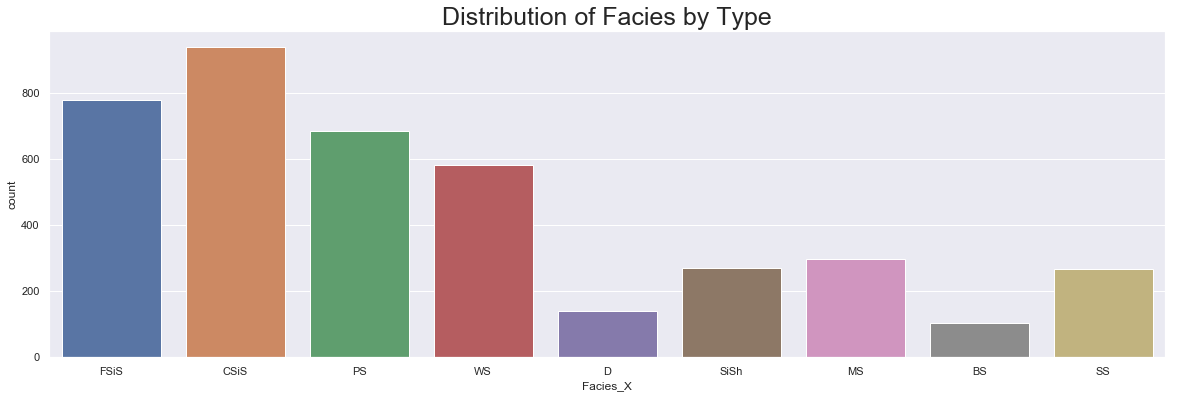

In [159]:
fig, axes = plt.subplots(figsize=(20,6))
sns.countplot(x="Facies_X", data=df_drop)
plt.title('Distribution of Facies by Type',fontsize=25)

This plot shows that Sandstone strongly represented. However, relative distribution doesnt have big swings

In [146]:
df_drop["Facies_X"].head()

0    FSiS
1    FSiS
2    FSiS
3    FSiS
4    FSiS
Name: Facies_X, dtype: object

Text(0.5, 0, 'PE')

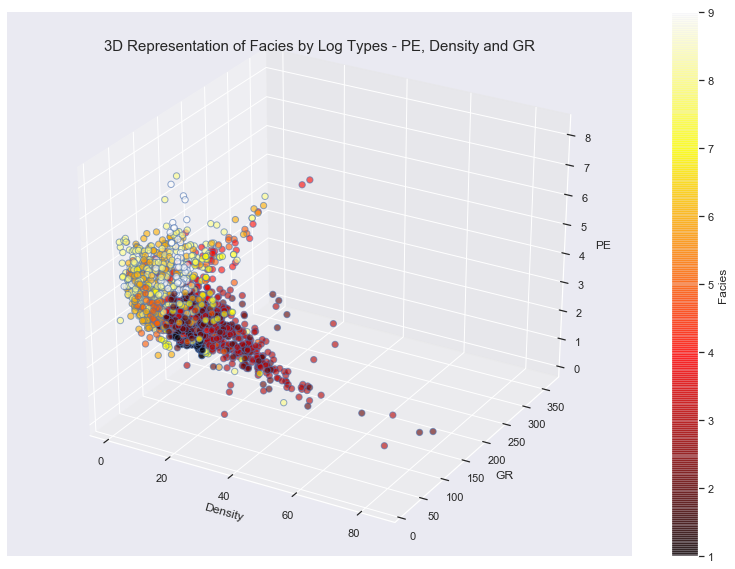

In [158]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
plt.title('3D Representation of Facies by Log Types - PE, Density and GR',fontsize=15)

xs = df_drop['PHIND']
ys = df_drop['GR']
zs = df_drop['PE']
pnt3d=ax.scatter(xs, ys, zs, c= df_drop['Facies'], cmap = plt.hot(),s=40, alpha=0.6, edgecolors='b')

cbar=plt.colorbar(pnt3d)
cbar.set_label("Facies")

ax.set_xlabel('Density')
ax.set_ylabel('GR')
ax.set_zlabel('PE')

3D Plot showing three features that based on Correlation Matrix (HeatMap) showed the highest correlation ( biggest explonatory power)
to Facies <br />
There are a few outliers that could be addressed on second pass of the models. <br />
Visually looks like there is some clustering of facies, hence they are not just randomly distributed

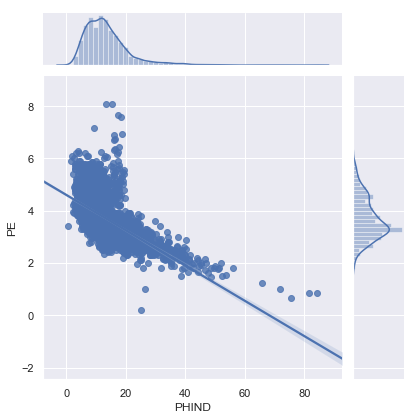

In [163]:
sns.jointplot("PHIND", "PE", data=df_drop, kind='reg')
#plt.title('Density vs PE with distribution',fontsize=15)
#Both of the main features seems to be normally distributed

/Users/lidag/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lidag/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


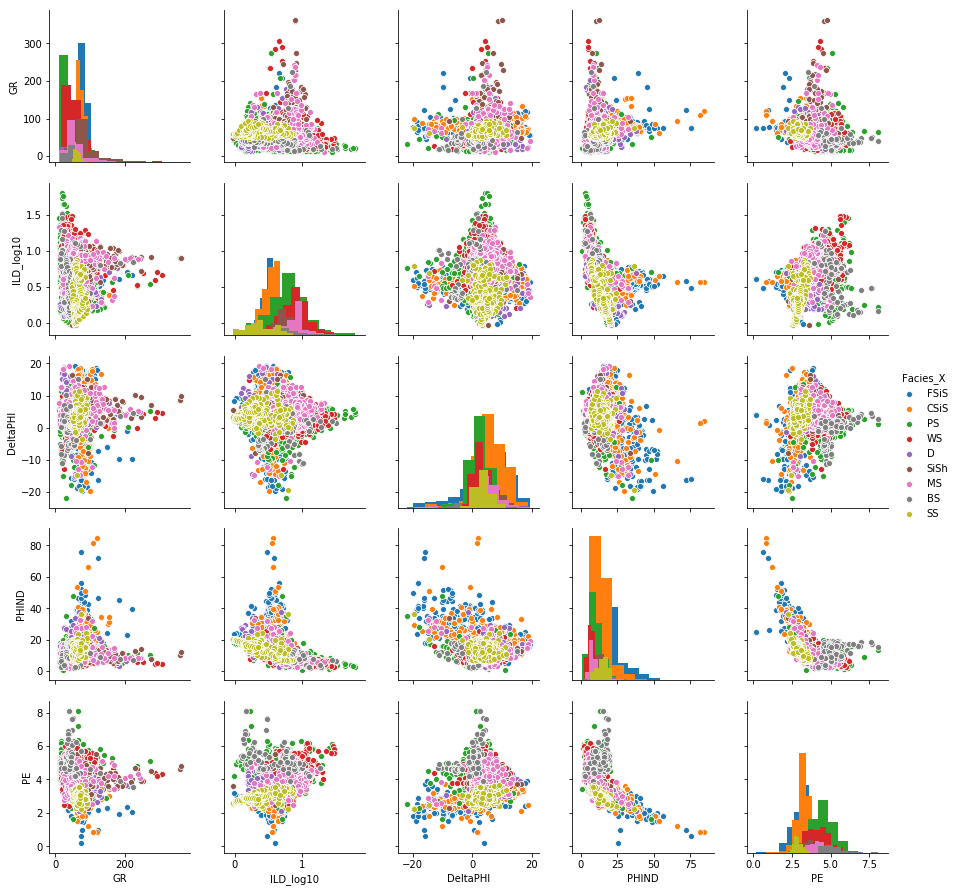

In [37]:
#drop formation, well name and depth columns from data analysis as those columns do not aid in understanding
#of data
# Check data to see if need to normalize 
features = df_drop[['GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE','Facies_X']]

g = sns.pairplot(features, diag_kind='hist', hue=('Facies_X'))

# Use Well - Cross H Cattle to predict PE 

In [38]:
df_PE=training_data
df_PE=df_PE[df_PE["Well Name"] == 'CROSS H CATTLE'] # extract one well to Predict PE
df_PE.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
2286,2,A1 SH,CROSS H CATTLE,2573.5,118.439,0.674494,6.3,9.95,3.631,1,1.000
2287,2,A1 SH,CROSS H CATTLE,2574.0,92.550,0.645226,9.9,13.05,3.450,1,0.987
2288,2,A1 SH,CROSS H CATTLE,2574.5,102.168,0.630021,12.0,14.50,3.364,1,0.974
2289,2,A1 SH,CROSS H CATTLE,2575.0,88.898,0.600319,15.1,16.05,3.187,1,0.961
2290,2,A1 SH,CROSS H CATTLE,2575.5,85.493,0.578639,13.6,15.90,3.099,1,0.947


In [39]:
df_PE.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'],
      dtype='object')

In order to predict PE use other Logs, geological models NM_M, Relpos and Facies information 

In [40]:
#Target 
y=df_PE['PE']
#Features
X=df_PE.drop(['Formation', 'Well Name','PE'], axis = 1)

In [41]:
X.shape

(501, 8)

In [46]:
X.head()


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,NM_M,RELPOS
2286,2,2573.5,118.439,0.674494,6.3,9.95,1,1.000
2287,2,2574.0,92.550,0.645226,9.9,13.05,1,0.987
2288,2,2574.5,102.168,0.630021,12.0,14.50,1,0.974
2289,2,2575.0,88.898,0.600319,15.1,16.05,1,0.961
2290,2,2575.5,85.493,0.578639,13.6,15.90,1,0.947


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)

In [48]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
scores=[]
LM = linear_model.LinearRegression()
LM.fit(X_train,y_train)
PE_calc=LM.predict(X_test)
LM_R2=r2_score(y_test, PE_calc)
print("R2 score for LR", LM_R2)
print("MSE LR:", mean_squared_error(y_test, PE_calc))
#scores=scores.apend(LM_R2)

R2 score for LR 0.8741233619531594
MSE LR: 0.05371354095449103


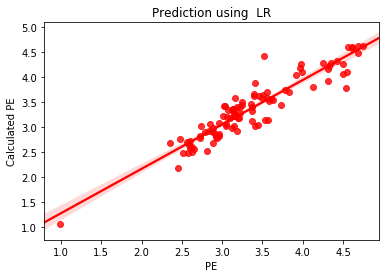

In [49]:
plt.title('Prediction using  LR')
plt.ylabel("Calculated PE")
sns.regplot(x=y_test,y= PE_calc,data=df_PE, color="red")

First well predicted PE at 87% confidence and small error of 0.05. Just to check do prediction on another well

# Validate the prediction by comparing predicted PE with Actual

In [50]:
PE_val=LM.predict(X)

In [51]:
PE_val.shape

(501,)

In [52]:
df_PE['PE_val']=PE_val

In [53]:
df_PE.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PE_val
2286,2,A1 SH,CROSS H CATTLE,2573.5,118.439,0.674494,6.3,9.95,3.631,1,1.000,3.384847
2287,2,A1 SH,CROSS H CATTLE,2574.0,92.550,0.645226,9.9,13.05,3.450,1,0.987,3.354446
2288,2,A1 SH,CROSS H CATTLE,2574.5,102.168,0.630021,12.0,14.50,3.364,1,0.974,3.325138
2289,2,A1 SH,CROSS H CATTLE,2575.0,88.898,0.600319,15.1,16.05,3.187,1,0.961,3.323170
2290,2,A1 SH,CROSS H CATTLE,2575.5,85.493,0.578639,13.6,15.90,3.099,1,0.947,3.289763


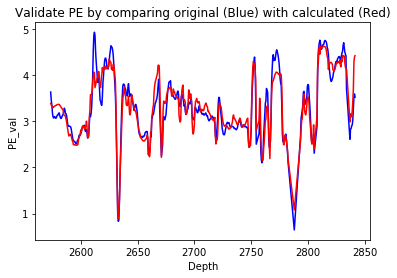

In [54]:
plt.title('Validate PE by comparing original (Blue) with calculated (Red)')
plt.ylabel("Cross H Cattle well")

sns.lineplot(x='Depth', y="PE", data=df_PE, color="blue")
sns.lineplot(x='Depth', y="PE_val", data=df_PE, color='red')

In [55]:
#PE_val
df_PE["PE"].corr(df_PE['PE_val'])

0.9378966138881237

Use Shrimplin well to do find model to predict PE

In [56]:
df_PE_2=training_data
df_PE_2=df_PE_2[df_PE_2["Well Name"] =='SHRIMPLIN'] #is done and dusted
df_PE_2.head()


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [57]:
#Target 
y=df_PE_2['PE']
#Features
X=df_PE_2.drop(['Formation', 'Well Name','PE',], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)

In [58]:
X.head()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,NM_M,RELPOS
0,3,2793.0,77.45,0.664,9.9,11.915,1,1.000
1,3,2793.5,78.26,0.661,14.2,12.565,1,0.979
2,3,2794.0,79.05,0.658,14.8,13.050,1,0.957
3,3,2794.5,86.10,0.655,13.9,13.115,1,0.936
4,3,2795.0,74.58,0.647,13.5,13.300,1,0.915


In [59]:
X.shape

(471, 8)

In [60]:
LM = linear_model.LinearRegression()
LM.fit(X_train,y_train)
PE_calc_2=LM.predict(X_test)
LM_R2=r2_score(y_test, PE_calc_2)
print("R2 score for LR", LM_R2)
print("MSE LR:", mean_squared_error(y_test, PE_calc_2))

R2 score for LR 0.7766401241131025
MSE LR: 0.18492564288331675


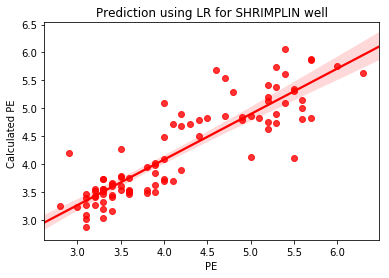

In [61]:
plt.title('Prediction using LR for SHRIMPLIN well')
plt.ylabel("Calculated PE ")
sns.regplot(x=y_test, y=PE_calc_2, data=df_PE_2, color="red")

In [62]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [63]:
RF = RandomForestRegressor(n_estimators =100, random_state = 4 ).fit(X_train, y_train)
y_pred=RF.predict(X_test)
RF_R2=r2_score(y_test, y_pred)
print("R2 score:RF",RF_R2 )
print("MSE_RF:", mean_squared_error(y_test, y_pred))

R2 score:RF 0.8770259554285041
MSE_RF: 0.1018135157894737


In [64]:
KNN = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
y_pred = KNN.predict(X_test)
KNN_R2=r2_score(y_test,y_pred)
print("R2 score_Knn:", KNN_R2)
print("MSE_Knn:", mean_squared_error(y_test, y_pred))

R2 score_Knn: 0.724908324901901
MSE_Knn: 0.2277557894736842


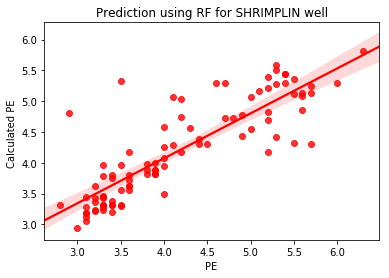

In [65]:
plt.title('Prediction using RF for SHRIMPLIN well')
plt.ylabel("Calculated PE ")
sns.regplot(x=y_test, y=y_pred, data=df_PE_2, color="red")

In [66]:
from sklearn.ensemble import GradientBoostingRegressor

In [67]:
GBR = GradientBoostingRegressor().fit(X_train, y_train)
y_pred = GBR.predict(X_test)
GBR_R2=r2_score(y_test,y_pred)
print("R2 score_GBR:", GBR_R2)
print("MSE_GBR:", mean_squared_error(y_test, y_pred))

R2 score_GBR: 0.8588567874214147
MSE_GBR: 0.1168562581845643


In [68]:
print("MSE_GBR:", mean_squared_error(y_test, y_pred))
results = pd.DataFrame({'Model' :["LM","KNN","RF",'GBR'],"Model's R2" :[LM_R2, KNN_R2, RF_R2,GBR_R2]})
results.sort_values(by="Model's R2", ascending=False)

MSE_GBR: 0.1168562581845643


,Model,Model's R2
2,RF,0.877026
3,GBR,0.858857
0,LM,0.776640
1,KNN,0.724908


depending of the input data dataset scores change but RF is still the best predictor  

 Results using Cattle well and Shrimlin:
For both wells RF with 100 estimators shows the best results. To predict PE for the two wells that do not have
the PE log use RF with 100 estimators
Now create data base with 7 wells and predict PE using all of the wells with complete data sets
Use scaler to scale data as logs might have different calibration and pairplot shows that data needs to be normalised 

# Create new Data Set with 7 wells for PE prediction

In [69]:
df_drop['Well Name'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
ALEXANDER D        466
NEWBY              463
LUKE G U           461
SHANKLE            449
KIMZEY A           439
NOLAN              415
CHURCHMAN BIBLE    404
Name: Well Name, dtype: int64

In [70]:
#create new database with 7 wells by dropping Alexander and Kimzy wells
df_8 = df_drop #new dataset for further analysis
df_8=df_8[df_8["Well Name"] !='ALEXANDER D']
df_8.shape
df_8['Well Name'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
NEWBY              463
LUKE G U           461
SHANKLE            449
KIMZEY A           439
NOLAN              415
CHURCHMAN BIBLE    404
Name: Well Name, dtype: int64

In [71]:
df_7 = df_8 #new dataset for further analysis
df_7=df_7[df_7["Well Name"] !='KIMZEY A']
df_7.shape
df_7['Well Name'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
NEWBY              463
LUKE G U           461
SHANKLE            449
NOLAN              415
CHURCHMAN BIBLE    404
Name: Well Name, dtype: int64

# Find module to predict PE using 7 wells

In [72]:
df_7.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_X
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [73]:
y=df_7['PE']
#Features
X=df_7.drop(['Formation','Well Name','PE','Facies_X'], axis = 1)
#scaler = preprocessing.StandardScaler().fit(X) 
#X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)

In [74]:
X.head()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,NM_M,RELPOS
0,3,2793.0,77.45,0.664,9.9,11.915,1,1.000
1,3,2793.5,78.26,0.661,14.2,12.565,1,0.979
2,3,2794.0,79.05,0.658,14.8,13.050,1,0.957
3,3,2794.5,86.10,0.655,13.9,13.115,1,0.936
4,3,2795.0,74.58,0.647,13.5,13.300,1,0.915


In [75]:
RF = RandomForestRegressor(n_estimators =100, random_state = 4 ).fit(X_train, y_train)
y_pred=RF.predict(X_test)
RF_R2=r2_score(y_test, y_pred)
print("R2 score:RF",RF_R2 )
print("MSE_RF:", mean_squared_error(y_test, y_pred))

R2 score:RF 0.8406879369282236
MSE_RF: 0.13076131928549994


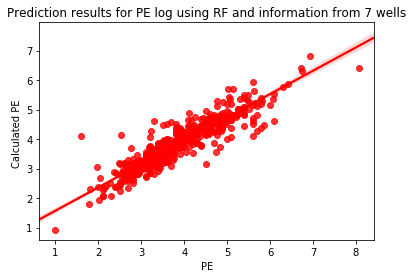

In [76]:
plt.title('Prediction results for PE log using RF and information from 7 wells')
plt.ylabel("Calculated PE ")
sns.regplot(x=y_test, y=y_pred, data=df_7, color="red")

# Predict PE for Kimzy well

In [77]:
df_PE_pred=training_data
df_PE_pred=df_PE_pred[df_PE_pred["Well Name"] =='KIMZEY A'] #have a set with only Kimzey A well
df_PE_pred.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1847,1,A1 SH,KIMZEY A,2918.5,73.816,0.769,5.226,11.3480,NaN,1,1.000
1848,1,A1 SH,KIMZEY A,2919.0,75.118,0.627,8.198,13.1640,NaN,1,0.978
1849,1,A1 SH,KIMZEY A,2919.5,72.434,0.535,10.867,15.0755,NaN,1,0.956
1850,2,A1 SH,KIMZEY A,2920.0,66.161,0.568,4.566,16.9050,NaN,1,0.933
1851,2,A1 SH,KIMZEY A,2920.5,63.104,0.650,2.083,15.8835,NaN,1,0.911


In [78]:

df_PE_pred['PE'] = df_PE_pred['PE'].replace(np.nan, 0)

In [79]:
df_PE_pred.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1847,1,A1 SH,KIMZEY A,2918.5,73.816,0.769,5.226,11.3480,0.0,1,1.000
1848,1,A1 SH,KIMZEY A,2919.0,75.118,0.627,8.198,13.1640,0.0,1,0.978
1849,1,A1 SH,KIMZEY A,2919.5,72.434,0.535,10.867,15.0755,0.0,1,0.956
1850,2,A1 SH,KIMZEY A,2920.0,66.161,0.568,4.566,16.9050,0.0,1,0.933
1851,2,A1 SH,KIMZEY A,2920.5,63.104,0.650,2.083,15.8835,0.0,1,0.911


In [85]:
X=df_PE_pred.drop(['Formation', 'Well Name','PE'], axis = 1)#features


In [86]:
X.shape

(439, 8)

In [87]:
X.head()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,NM_M,RELPOS
1847,1,2918.5,73.816,0.769,5.226,11.3480,1,1.000
1848,1,2919.0,75.118,0.627,8.198,13.1640,1,0.978
1849,1,2919.5,72.434,0.535,10.867,15.0755,1,0.956
1850,2,2920.0,66.161,0.568,4.566,16.9050,1,0.933
1851,2,2920.5,63.104,0.650,2.083,15.8835,1,0.911


In [88]:
PE_Kimszy=RF.predict(X)

In [89]:
PE_Kimszy.shape


(439,)

In [90]:
df_PE_pred['PE']=PE_Kimszy
df_PE_pred.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1847,1,A1 SH,KIMZEY A,2918.5,73.816,0.769,5.226,11.3480,3.53497,1,1.000
1848,1,A1 SH,KIMZEY A,2919.0,75.118,0.627,8.198,13.1640,3.29225,1,0.978
1849,1,A1 SH,KIMZEY A,2919.5,72.434,0.535,10.867,15.0755,3.28637,1,0.956
1850,2,A1 SH,KIMZEY A,2920.0,66.161,0.568,4.566,16.9050,3.11763,1,0.933
1851,2,A1 SH,KIMZEY A,2920.5,63.104,0.650,2.083,15.8835,2.93982,1,0.911


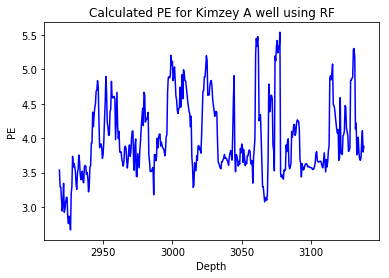

In [91]:
plt.title('Calculated PE for Kimzey A well using RF')
#plt.ylabel("Calculated PE for Kimzey A well ")

sns.lineplot(x='Depth', y="PE", data=df_PE_pred, color="blue")

In [92]:
#df_PE_pred['PE']=df_PE_pred['Predicted PE']

In [93]:
df_PE_pred.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1847,1,A1 SH,KIMZEY A,2918.5,73.816,0.769,5.226,11.3480,3.53497,1,1.000
1848,1,A1 SH,KIMZEY A,2919.0,75.118,0.627,8.198,13.1640,3.29225,1,0.978
1849,1,A1 SH,KIMZEY A,2919.5,72.434,0.535,10.867,15.0755,3.28637,1,0.956
1850,2,A1 SH,KIMZEY A,2920.0,66.161,0.568,4.566,16.9050,3.11763,1,0.933
1851,2,A1 SH,KIMZEY A,2920.5,63.104,0.650,2.083,15.8835,2.93982,1,0.911


In [94]:
df_PE_pred.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'],
      dtype='object')

# Predict PE for Alexander D well using RF prediction from 7 wells

In [95]:
df_PE_pred_A=training_data
df_PE_pred_A=df_PE_pred_A[df_PE_pred_A["Well Name"] =='ALEXANDER D'] #have a set with only Alexander D well
df_PE_pred_A.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,3,A1 SH,ALEXANDER D,2887.5,88.71,0.612,6.7,10.605,NaN,1,1.000
472,3,A1 SH,ALEXANDER D,2888.0,92.71,0.583,11.0,12.515,NaN,1,0.974
473,3,A1 SH,ALEXANDER D,2888.5,94.54,0.579,12.0,13.410,NaN,1,0.949
474,3,A1 SH,ALEXANDER D,2889.0,95.31,0.579,11.5,13.750,NaN,1,0.923
475,3,A1 SH,ALEXANDER D,2889.5,93.79,0.572,10.3,13.405,NaN,1,0.897


In [96]:
X=df_PE_pred_A.drop(['Formation', 'Well Name','PE'], axis = 1)#features

In [97]:
X.head()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,NM_M,RELPOS
471,3,2887.5,88.71,0.612,6.7,10.605,1,1.000
472,3,2888.0,92.71,0.583,11.0,12.515,1,0.974
473,3,2888.5,94.54,0.579,12.0,13.410,1,0.949
474,3,2889.0,95.31,0.579,11.5,13.750,1,0.923
475,3,2889.5,93.79,0.572,10.3,13.405,1,0.897


In [98]:
X.shape

(466, 8)

In [99]:
PE_Alexander=RF.predict(X)

In [100]:
PE_Alexander.shape

(466,)

In [101]:
df_PE_pred_A['PE']=PE_Alexander

In [102]:
df_PE_pred_A.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,3,A1 SH,ALEXANDER D,2887.5,88.71,0.612,6.7,10.605,3.74112,1,1.000
472,3,A1 SH,ALEXANDER D,2888.0,92.71,0.583,11.0,12.515,3.71066,1,0.974
473,3,A1 SH,ALEXANDER D,2888.5,94.54,0.579,12.0,13.410,3.59444,1,0.949
474,3,A1 SH,ALEXANDER D,2889.0,95.31,0.579,11.5,13.750,3.55938,1,0.923
475,3,A1 SH,ALEXANDER D,2889.5,93.79,0.572,10.3,13.405,3.56372,1,0.897


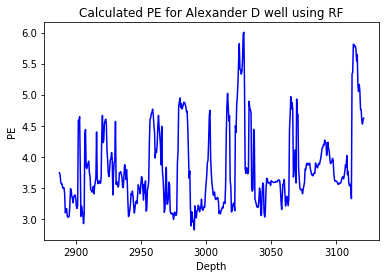

In [103]:
plt.title("Calculated PE for Alexander D well using RF")
#plt.ylabel("Calculated PE for Al)
sns.lineplot(x='Depth', y='PE', data=df_PE_pred_A, color="blue")
#sns.lineplot(x='Depth', y="PE", data=df_PE_pred, color="blue")

# Choose model to predict Facies from 9 wells

First need to combine data frame with 7 wells and data frame for well Kimzey and Alexander that now both have
calculated PE curves derived using RF prediction model

In [104]:
df_7.shape[0]+ df_PE_pred.shape[0]+ df_PE_pred_A.shape[0]

4069

In [105]:
df_7.head(2)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_X
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS


In [106]:
df_PE_pred.head(2)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1847,1,A1 SH,KIMZEY A,2918.5,73.816,0.769,5.226,11.348,3.53497,1,1.000
1848,1,A1 SH,KIMZEY A,2919.0,75.118,0.627,8.198,13.164,3.29225,1,0.978


In [107]:
frames=[df_7, df_PE_pred,df_PE_pred_A]
df_9=pd.concat(frames)
#df_9=pd.merge[df_7, df_PE_pred]

/Users/lidag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [108]:
df_9.shape

(4069, 12)

In [109]:
df_9.columns

Index(['DeltaPHI', 'Depth', 'Facies', 'Facies_X', 'Formation', 'GR',
       'ILD_log10', 'NM_M', 'PE', 'PHIND', 'RELPOS', 'Well Name'],
      dtype='object')

In [110]:
df_9['Well Name'].value_counts()

CROSS H CATTLE     501
SHRIMPLIN          471
ALEXANDER D        466
NEWBY              463
LUKE G U           461
SHANKLE            449
KIMZEY A           439
NOLAN              415
CHURCHMAN BIBLE    404
Name: Well Name, dtype: int64

In [111]:
#Scaling data
# features to be used for classification are 

feature_class= df_9[['Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']]
X=feature_class
#Target is Facies
y = df_9['Facies']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
scaled_features = scaler.transform(X)

/Users/lidag/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/lidag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [112]:
X.shape

(4069, 8)

Based on the heatmap, features that help in facies classificaion are 
Curves : PE, GR, Resistivity (ILD_log10), Both Densities ('DeltaPHI', 'PHIND'). 
Geologically imposed attributes NM_M and RELPOS have to be used to classify facies and places them at the correct depth

In [113]:
X.head()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [114]:
df_9['Facies']

0      3
1      3
2      3
3      3
4      3
      ..
932    8
933    8
934    8
935    8
936    8
Name: Facies, Length: 4069, dtype: int64

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix 

In [117]:
GBN=GaussianNB().fit(X_train,y_train)
Facies_predict = GBN.predict(X_test)

# Evaluate Results and Compare models

In [119]:
print(classification_report(y_test,Facies_predict))
print(confusion_matrix(y_test,Facies_predict))

              precision    recall  f1-score   support

           1       0.35      0.85      0.49        55
           2       0.52      0.57      0.55       166
           3       0.81      0.31      0.45       159
           4       0.66      0.47      0.55        62
           5       0.57      0.08      0.15        48
           6       0.45      0.80      0.58       133
           7       0.32      0.37      0.34        27
           8       0.52      0.08      0.14       141
           9       0.20      0.83      0.32        23

   micro avg       0.46      0.46      0.46       814
   macro avg       0.49      0.49      0.40       814
weighted avg       0.55      0.46      0.42       814

[[ 47   7   1   0   0   0   0   0   0]
 [ 61  95  10   0   0   0   0   0   0]
 [ 26  78  50   1   0   1   3   0   0]
 [  0   0   0  29   0  24   4   0   5]
 [  1   1   0   2   4  31   6   0   3]
 [  0   1   0   7   1 107   3   7   7]
 [  0   0   0   3   0   5  10   3   6]
 [  0   0   1   2   2 

In [120]:
models=[("DTC", DecisionTreeClassifier()),('KNN',KNeighborsClassifier()),
                                 ('SVC',SVC()),('GNB', GaussianNB()), ('RFC',RandomForestClassifier(n_estimators=200))]


/Users/lidag/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.7063882063882064, 0.687960687960688, 0.5798525798525799, 0.457002457002457, 0.8022113022113022]


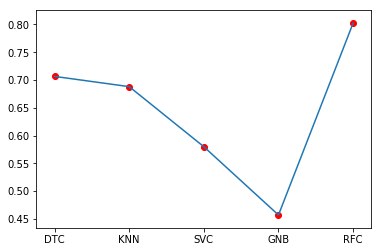

In [121]:
results =[]

for name, model in models:
    _model= model
    _model.fit(X_train,y_train)
    _prediction=_model.predict(X_test)
    _confusion=confusion_matrix(y_test, _prediction)
    _accuracy=accuracy_score(y_test, _prediction)
    #m_predictions.append(_predictions)
    #trained_models.append(_model)  #append so results will not be overriden
    model_details=[_model,_prediction,_confusion, _accuracy]
    results.append(model_details)
    
score=[]
model_names=['DTC','KNN',"SVC","GNB",'RFC']
for element in results:
    score.append(element[3])
print(score)

plt.plot(model_names,score)
plt.scatter(model_names,score,c='red', edgecolors='red')    
    
plt.show()


Based on quick analysis comparing models RFC shows the best result.
Can use this and tune up the paramenters

In [122]:
rfc = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)

In [123]:
rfc_pred = rfc.predict(X_test)

In [124]:
print(classification_report(y_test,rfc_pred))
print(confusion_matrix(y_test,rfc_pred))


              precision    recall  f1-score   support

           1       0.98      0.73      0.83        55
           2       0.81      0.89      0.85       166
           3       0.84      0.84      0.84       159
           4       0.88      0.79      0.83        62
           5       0.69      0.75      0.72        48
           6       0.76      0.77      0.77       133
           7       0.81      0.78      0.79        27
           8       0.81      0.81      0.81       141
           9       0.82      0.78      0.80        23

   micro avg       0.81      0.81      0.81       814
   macro avg       0.82      0.79      0.80       814
weighted avg       0.82      0.81      0.81       814

[[ 40  11   4   0   0   0   0   0   0]
 [  1 148  17   0   0   0   0   0   0]
 [  0  22 133   3   0   0   0   1   0]
 [  0   0   0  49   4   5   2   2   0]
 [  0   1   2   0  36   5   1   3   0]
 [  0   0   1   3   7 103   2  17   0]
 [  0   0   0   0   1   2  21   2   1]
 [  0   0   1   1   4 

In [125]:
y_test.shape

(814,)

# Choose parameters for Random Forest

In [126]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)
print(r2_score(y_test, y_pred))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.0s
/Users/lidag/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/lidag/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/lidag/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

0.8900648782538546


In [127]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [128]:
print(classification_report(y_test,y_pred,))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.98      0.80      0.88        55
           2       0.83      0.86      0.85       166
           3       0.82      0.84      0.83       159
           4       0.88      0.79      0.83        62
           5       0.69      0.77      0.73        48
           6       0.76      0.77      0.76       133
           7       0.88      0.78      0.82        27
           8       0.80      0.82      0.81       141
           9       0.83      0.83      0.83        23

   micro avg       0.82      0.82      0.82       814
   macro avg       0.83      0.81      0.82       814
weighted avg       0.82      0.82      0.82       814

[[ 44   6   4   0   1   0   0   0   0]
 [  1 143  22   0   0   0   0   0   0]
 [  0  21 134   3   0   0   0   1   0]
 [  0   0   0  49   3   7   1   2   0]
 [  0   2   1   0  37   5   0   3   0]
 [  0   0   1   3   7 102   2  18   0]
 [  0   0   0   0   1   2  21   2   1]
 [  0   0   1   1   5 

Conclusions: Finding best parameters for RF improved results only slightly

In [129]:
df_cm=confusion_matrix(y_test,y_pred)

In [130]:
y_test.shape
#convert confusion matrix into dataframe


(814,)

In [131]:
array=[[ 44 , 6,   4 ,  0  , 1 ,  0 ,  0 ,  0 ,  0],
 [  1, 145 , 20,  0  , 0 ,  0 ,  0 ,  0 ,  0],
 [  0 , 22, 133,   3 ,  0 ,  0 ,  0 ,  1,   0],
 [  0,   0 ,  0,  49  , 3 ,  7 ,  1 ,  2 ,  0],
 [  0 ,  2 ,  1  , 0  ,36 ,  5,   0 ,  4 ,  0],
 [  0  , 0 ,  1 ,  3 ,  6, 103  , 2,  18,   0],
 [  0  , 0 ,  0 ,  0 ,  1 ,  2 , 21,   2 ,  1],
 [  0 ,  0  , 1,   1 ,  5,  17 ,  0 ,114 ,  3],
 [  0 ,  0 ,  0 ,  0 ,  0 ,  2,   0 ,  1 , 20]]
df_cm=pd.DataFrame(array, range(9) ,range(9))

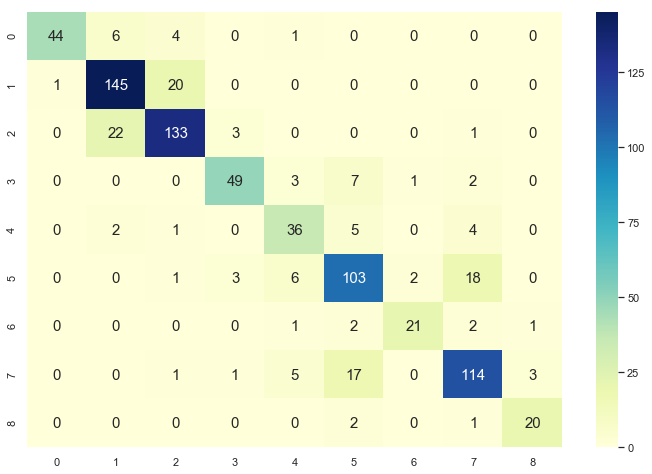

In [132]:
plt.figure(figsize = (12,8))
sns.set(font_scale=1)#for label size
sns.heatmap(df_cm, annot=True, cmap="YlGnBu", annot_kws={"size": 15}, fmt ='g')

# Getting Well plots set up

In [133]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
def label_facies(row, labels):
    return labels[ row['Facies'] -1]

In [134]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 15))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((13*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.9)

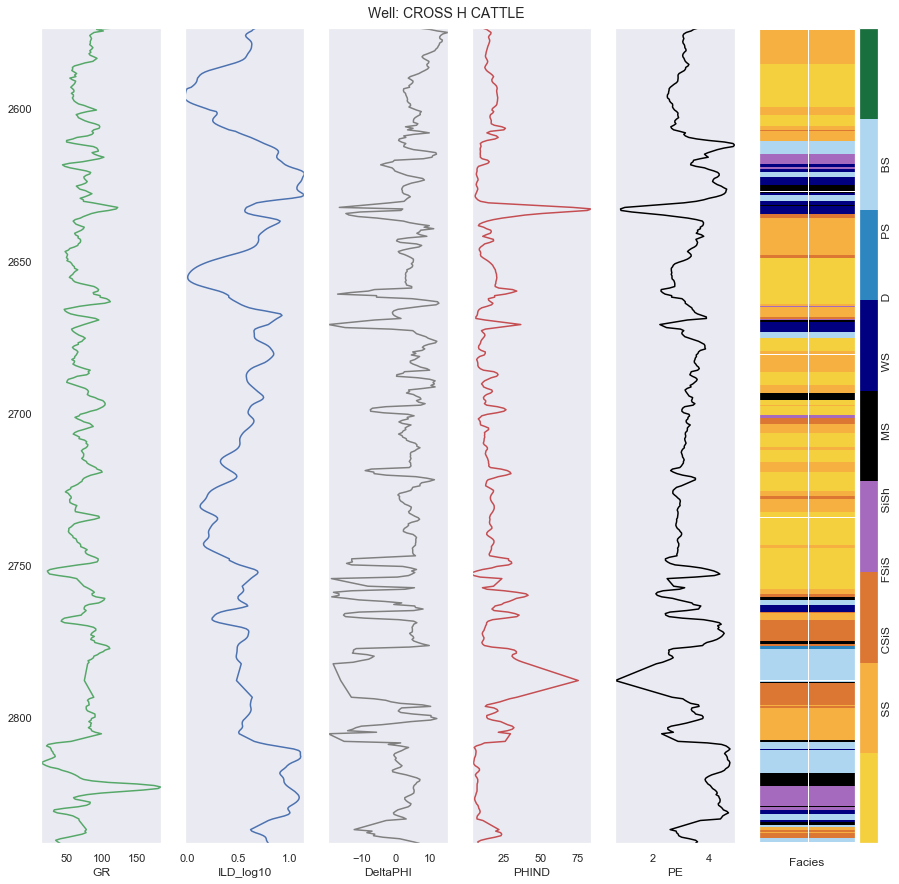

In [135]:
make_facies_log_plot(df_9[df_9['Well Name'] == 'CROSS H CATTLE'], facies_colors)

# Apply RF model to see how well it will predict facies

In [136]:
X.head()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [137]:

#X=df_9.drop(['Facies_X','Formation','Well Name','Facies','Prediction'], axis = 1)
X.head()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [138]:
X.shape

(4069, 8)

In [139]:
#SVC_classifier_conf.fit(X,y)
#pred = SVC_classifier_conf.predict(X)

#X = training_data
#X['Prediction'] = pred
#rf_random.fit(X,y)
pred_facies=rf_random.predict(X)
X = df_9
X['Prediction'] = pred_facies



In [140]:
pred_facies

array([3, 3, 3, ..., 8, 8, 8])

In [141]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12,12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=10,y=0.94)

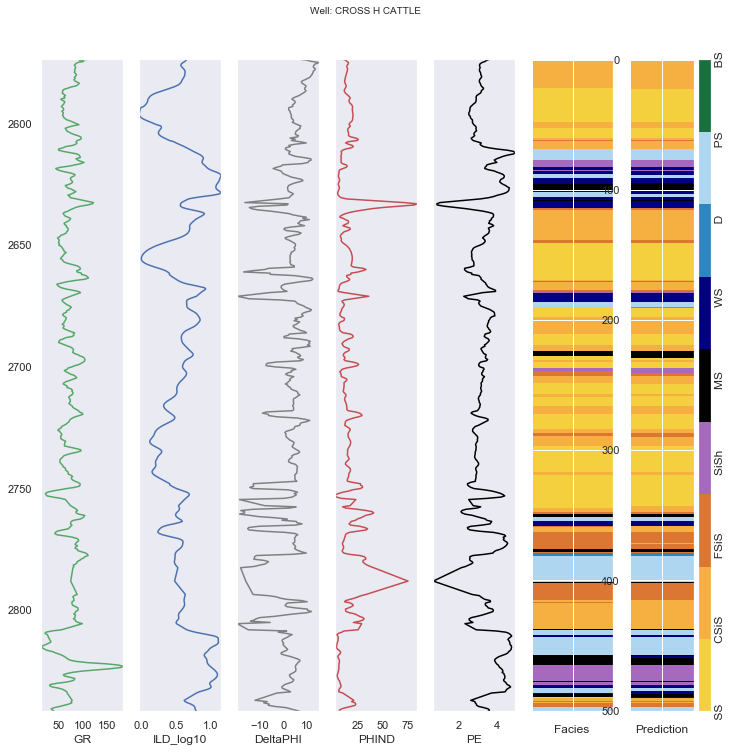

In [142]:
compare_facies_plot(X[X['Well Name'] == 'CROSS H CATTLE'], 'Prediction', facies_colors)

In [143]:

X['Facies'].corr(X['Prediction'] )

0.9889757164378405

98% seems like there might be an overfitting issue.<br />
Need to investigate further at later time. Overall seems that Predicted Facies are higher frequecies or showing more details than data from original facies that come from core description.<br />
Next step is to use this prediction and apply to one of the wells that did not have facies from core. Will finish when get time
